In [1]:
import numpy as np

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line as draw_line
from skimage import data
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.transform import probabilistic_hough_line
import random 

# Load image"
image_path = "/Users/nshelton/Pictures/gundam_title.png"
# image_path = "/Users/nshelton/Pictures/akira.jpeg"
# image_path = "/Users/nshelton/Pictures/somedragon.jpg"

# image_path = "/Users/nshelton/Pictures/amplifier_schematic.png"
# image_path = "/Users/nshelton/Pictures/stairs.png"

image = cv2.imread(image_path)
print(image.shape)

# image[:,:,1] = image[:,:,0]
# image[:,:,2] = image[:,:,0]

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image_gray = cv2.resize(image_gray, (-1,-1), fx = 2, fy = 2)
# _ , filtered =  cv2.threshold(image_gray, 150, 505, cv2.THRESH_BINARY_INV)

filtered = image_gray
# sigma = 2
# min_canny = 2
# max_canny = 100
# filtered = canny(image_gray, sigma, min_canny, max_canny).astype(np.uint8) * 255

filtered = 255 - filtered

# filtered = filtered[:, :-50]
filtered = filtered[0:200, 0:300]


# filtered = filtered[950:1000, 1150:1200]
cv2.imwrite("filtered.png", filtered)

(276, 1200, 3)


True

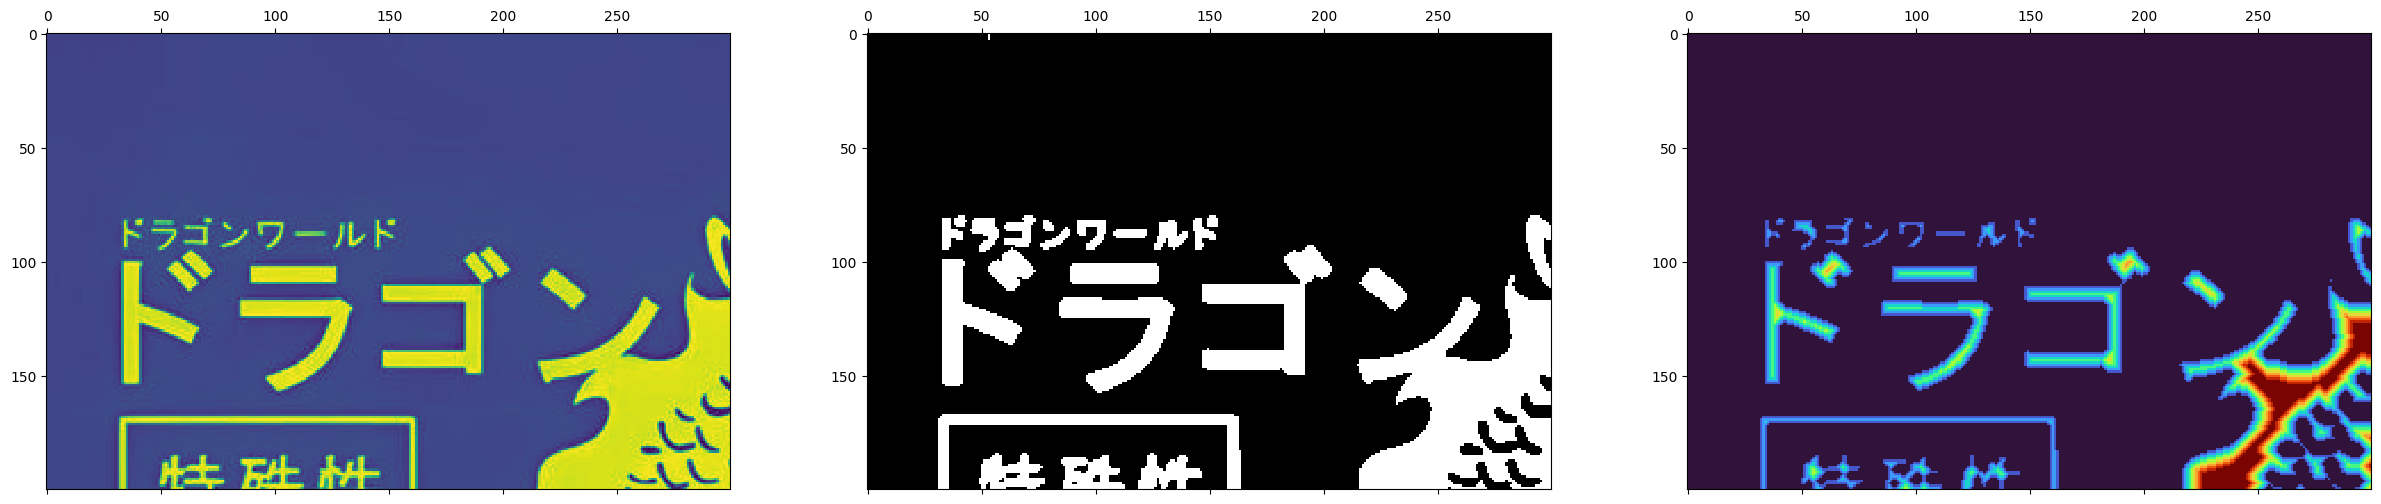

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.matshow(filtered)

erode_stack = filtered.copy()
erode_stack = cv2.blur(erode_stack, (3,3))

erode_stack = cv2.adaptiveThreshold(erode_stack, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  cv2.THRESH_BINARY, 131, -1)
ax2.matshow(erode_stack, cmap="gray")

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

distance_field = []
for i in range(10) : 
    erode_stack = cv2.erode(erode_stack, kernel)
    distance_field.append(erode_stack)

distance_field =  (np.array(distance_field) > 0).sum(axis=0).astype(np.float32)
ax3.matshow(distance_field, cmap="turbo")

In [26]:
field = distance_field.copy()

# for i in range(10):
# field = cv2.blur(field, (3,3))

from pathUtils import *

def lookupxy(raster, xy):
    if (
        int(xy[1]) >= 0
        and int(xy[1]) < raster.shape[0]
        and int(xy[0]) >= 0
        and int(xy[0]) < raster.shape[1]
    ):
        return raster[int(xy[1]), int(xy[0])]
    return np.nan


def maxLoc(img):
    _, _, _, max_loc = cv2.minMaxLoc(img)
    return max_loc


def maxNearby(img, pos, r=5):

    maxval = 0
    maxpos = [0, 0]

    for dx in np.arange(-r, r+1, 1):
        for dy in np.arange(-r, r+1, 1):
            if np.linalg.norm([dx, dy]) > r:
                continue
            if 0 <= pos[1] + dy < img.shape[0] and 0 <= pos[0] + dx < img.shape[1]:
                value = img[pos[1] + dy, pos[0] + dx]
                if value > maxval:
                    maxpos = pos + np.array([dx, dy])
                    maxval = value

    return maxpos


line_radius = 1
search_radius = 2
dthresh = 0
# field[field < 2] = 0

paths = []
for j in range(3000):
    pos = maxLoc(field)
    path = []

    for i in range(10000):
        pos = maxNearby(field, pos, search_radius)
        val = field[pos[1], pos[0]]
        
        if val <= dthresh:
            break

        path.append(pos)
        if line_radius == 1:
            field[pos[1], pos[0]] = 0
        else:
            cv2.circle(field, pos, line_radius, 0, -1)

    paths.append(path)

    render = ((field.astype(np.float32) / field.max()) * 255).astype(np.uint8)

    cv2.imwrite("remaining_ink.png", render)


/var/folders/4n/l5_t325s5t59l1gqv4jd3h7c0000gn/T/ipykernel_21573/1218949454.py:67: RuntimeWarning: invalid value encountered in divide
  render = ((field.astype(np.float32) / field.max()) * 255).astype(np.uint8)
/var/folders/4n/l5_t325s5t59l1gqv4jd3h7c0000gn/T/ipykernel_21573/1218949454.py:67: RuntimeWarning: invalid value encountered in cast
  render = ((field.astype(np.float32) / field.max()) * 255).astype(np.uint8)


In [28]:

print(paths)
path_list = [[p for p in path] for path in paths if len(path) > 1]
RENDER_SCALE = 0.4
render_img = plotPaths(path_list, RENDER_SCALE)
cv2.imwrite("render.png", render_img)


[[array([292, 127]), array([292, 128]), array([292, 129]), array([292, 130]), array([292, 131]), array([293, 130]), array([293, 128]), array([293, 127]), array([293, 129]), array([293, 131]), array([293, 132]), array([293, 133]), array([292, 134]), array([292, 135]), array([292, 136]), array([292, 137]), array([291, 138]), array([291, 139]), array([290, 140]), array([289, 141]), array([288, 142]), array([287, 143]), array([286, 144]), array([285, 145]), array([284, 146]), array([283, 147]), array([282, 148]), array([281, 149]), array([280, 150]), array([279, 151]), array([278, 151]), array([277, 152]), array([276, 153]), array([274, 153]), array([273, 154]), array([271, 154]), array([269, 154]), array([267, 154]), array([265, 154]), array([263, 154]), array([261, 154]), array([259, 154]), array([257, 154]), array([255, 154]), array([253, 154]), array([251, 154]), array([250, 153]), array([249, 152]), array([248, 151]), array([247, 151]), array([248, 150]), array([248, 148]), array([247

True

In [29]:


from tqdm import tqdm 
path_list = [[p for p in path] for path in paths if len(path) > 1]

print(len(paths))
print(len(path_list))

merge_threshold = 2

for i in tqdm(range(len(path_list))):
    len_before = len(path_list)
    path_list = merge_one_path_kd(path_list, merge_threshold)
    if len_before == len(path_list):
        break

def getPathLength(path):
    length = 0
    for i in range(len(path) - 1):
        length += np.linalg.norm(path[i] - path[i+1])
    return length

path_list = close_loops(path_list, threshold=2)
path_list  = [np.array(path) for path in path_list]

path_list = [path for path in path_list if getPathLength(path) > 2]
path_list = smooth_all_2(path_list, 0.01)
path_list = simplify_all(path_list, 0.001)
path_list = smooth_all_2(path_list, 0.5)
path_list = simplify_all(path_list, 0.1)

RENDER_SCALE = 0.4
render_img = plotPaths(path_list, RENDER_SCALE)
cv2.imwrite("render.png", render_img)

3000
157


 21%|██        | 33/157 [00:00<00:00, 442.37it/s]


True

In [27]:
path_list = smooth_all_2(path_list, 0.5)
RENDER_SCALE = 0.5
render_img = plotPaths(path_list, RENDER_SCALE)
cv2.imwrite("render.png", render_img)

True

In [ ]:
import json
import uuid

projects_folder = "/Users/nshelton/Hephaestus/projects"

def writePlot(paths):
    dictionary = {
        "created_time": "4/7/2024 4:42:27 PM",
        "modified_time": "4/7/2024 6:27:36 PM",
        "camera_position": [100, 100],
        "zoom": 10.702,
        "aspect": 0.563,
        "dom_element": {},
        "plot_models": [],
    }

    dictionary["plot_models"].append(
        {
            "position": {"x": 0, "y": 0},
            "paths": [path.tolist() for path in path_list],
            "scale": 0.1,
            "id": str(uuid.uuid4()),
            "state": "none",
        }
    )


    with open(projects_folder + "/somedragon_df.json", "w") as outfile:
        json.dump(dictionary, outfile)

writePlot(path_list)


In [ ]:
# def lookupxy(raster, xy):
#     if int(xy[1]) > 0 and int(xy[1]) < raster.shape[0] and  int(xy[0]) > 0 and int(xy[0]) < raster.shape[1]:
#         return raster[int(xy[1]), int(xy[0])]
#     return np.nan

# from pathUtils import * 

# from scipy.spatial import KDTree

# points.shape

# paths = []
# visited = np.zeros(values.shape)

# start_idx = int(random.random()* 1000)
# print(start_idx, values[start_idx], points[start_idx])

# path = []
# current_idx = start_idx

# for i in range(1000):
#     tree = KDTree(points[visited == 0])
#     pos = points[current_idx]
#     path.append(pos)
#     visited[current_idx] = 1

#     flow = lookupxy(flow_field, pos)
#     magnitude = np.linalg.norm(flow)
#     print(pos, flow)
#     if (np.isnan(magnitude)):
#         break

#     query_point = pos + flow
#     distance, idx = tree.query(query_point, k=2)

#     if (distance[1] > 10) : 
#         break

#     current_idx = idx[1]

# print(len (path))
# paths.append(path)

# path_render = plotPaths(paths, 1)
# cv2.imwrite("render.png", path_render )

In [ ]:
import cv2
import numpy as np

from pathUtils import *

remaining_ink = filtered.copy()
all_strokes_raster = np.ones(remaining_ink.shape) * 255

all_paths = []

while len(all_paths) < 500 and remaining_ink.sum() > 10:

    def lookupxy(raster, xy):
        if int(xy[1]) > 0 and int(xy[1]) < raster.shape[0] and  int(xy[0]) > 0 and int(xy[0]) < raster.shape[1]:
            return raster[int(xy[1]), int(xy[0])]
        return np.nan


    def placeStroke(input_raster, start):
        img = input_raster.copy()
        path = []
        pos = np.array(start)

        window = 2

        max_val = lookupxy(input_raster, pos)

        while max_val > 0:
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(
                img[
                    pos[1] - window : pos[1] + window + 1,
                    pos[0] - window : pos[0] + window + 1,
                ]
            )
            pos += np.array(max_loc) - window
            path.append(pos.copy())
            cv2.circle(img, pos, window - 1, 0, -1)

        return path

    def placeStrokeOrthogonalGradient(input_raster, flow_field, start):
        img = input_raster.copy()
        path = []
        pos = np.array(start, np.float32)
        print("start at", pos, lookupxy(img, pos))

        speed = 2
        while (
            int(pos[0]) < img.shape[1] and int(pos[1]) < img.shape[0]
            and lookupxy(img, pos) > 0
        ):
            path.append(pos.copy())
            cv2.circle(img, (round(pos[1]), round(pos[0])), speed , 0, -1)

            flow = lookupxy(flow_field, pos)
            magnitude = np.linalg.norm(flow)
            print("flow", flow, magnitude, pos)
            if magnitude < 0.001:
                break

            delta = speed * flow / magnitude
            print("delta", delta)
            pos += delta
            print("newpos ",pos, img.shape, lookupxy(img, pos))

        return path

    line_thickness = 2

    def rasterStroke(dims, path):
        print(len(path))

        img = np.zeros(dims)

        if (len(path)) == 1:
            cv2.circle(
                img, (round(path[0][0]), round(path[0][1])), line_thickness, 255, -1
            )

        for i in range(len(path) - 1):
            a = (round(path[i][0]), round(path[i][1]))
            b = (round(path[i + 1][0]), round(path[i + 1][1]))
            cv2.line(img, a, b, 255, line_thickness, cv2.LINE_AA)

        return img

    print(remaining_ink.sum(), "\t", len(all_paths), end="\t\t\t\r")
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(remaining_ink)

    # new_stroke = placeStroke(remaining_ink, max_loc)
    new_stroke = placeStrokeOrthogonalGradient(remaining_ink, flow_field, max_loc)



    print("new_stroke", new_stroke)
    all_paths.append(new_stroke)
    stroke_raster = rasterStroke(remaining_ink.shape, new_stroke)
    remaining_ink = np.clip(remaining_ink - stroke_raster, 0, 255)
    all_strokes_raster = np.clip(
        all_strokes_raster.astype(np.int32) - stroke_raster.astype(np.int32) * 255,
        0,
        255,
    ).astype(np.uint8)

    cv2.imwrite("current_stroke.png", (all_strokes_raster).astype(np.uint8))
    cv2.imwrite("remaining_ink.png", remaining_ink)

# cv2.imwrite("current_stroke.png",  (all_strokes_raster).astype(np.uint8))
path_list = [[p.tolist() for p in path] for path in all_paths if len(path) > 1]

print(len(path_list))

RENDER_SCALE = 0.5
# connect_close_paths(path_list)
render_img = plotPaths(path_list, RENDER_SCALE)
cv2.imwrite("render.png", render_img)

In [ ]:
from tqdm import tqdm


import numpy as np
from scipy.spatial import KDTree
 
path_list = [[p.tolist() for p in path] for path in all_paths if len(path) > 1]

print(len(path_list))

merge_threshold = 5

for i in tqdm(range(len(path_list))):
    len_before = len(path_list)
    path_list = merge_one_path_kd(path_list, merge_threshold)
    if len_before == len(path_list):
        break

print("merged to", len(path_list))


path_list = close_loops(path_list)

print("closed loops", len(path_list))

path_list  = [np.array(path) for path in path_list]

for _ in range(1):
    path_list = smooth_all_2(path_list, 0.01)

print("smoothed 1", len(path_list))

path_list = simplify_all(path_list, 0.001)

print("simplify_all 1", len(path_list))

for _ in range(1):
    path_list = smooth_all_2(path_list, 0.1)

print("smoothed 2", len(path_list))

path_list = simplify_all(path_list, 0.1)
print("simplify 2", len(path_list))

RENDER_SCALE = 0.5
# connect_close_paths(path_list)
render_img = plotPaths(path_list, RENDER_SCALE)
cv2.imwrite("render.png", render_img)


import json 
import uuid

projects_folder = "/Users/nshelton/Hephaestus/projects"

def writePlot(paths):
    dictionary = {
        "created_time": "4/7/2024 4:42:27 PM",
        "modified_time": "4/7/2024 6:27:36 PM",
        "camera_position": [100, 100],
        "zoom": 10.702,
        "aspect": 0.563,
        "dom_element": {},
        "plot_models": [],
    }

    dictionary["plot_models"].append(
        {
            "position": {"x": 0, "y": 0},
            "paths": [path.tolist() for path in path_list],
            "scale": 0.03,
            "id": str(uuid.uuid4()),
            "state": "none",
        }
    )


    with open(projects_folder + "/akiraflow.json", "w") as outfile:
        
        json.dump(dictionary, outfile)


writePlot(path_list)